iLQR in jax. 
 * Cost
 * Derivatives
 * Q terms, gains, V-terms

In [1]:
import jax
from jax import numpy as np
from jax.lax import scan
from jax import vmap, jit
import numpy as onp
from scipy.interpolate import interp1d

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("RdYlBu", 8)

import sys
sys.path.append("../src/")
import arm_model
import ilqr_arm

/home/mkp127/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Model

In [2]:
with open('../data/arm_dt10.pickle', 'rb') as handle:
    d = pickle.load(handle)
print(d.keys())
m_trj = 100 * d['torques']

dict_keys(['torques', 'positions', 'states'])


In [3]:
x_trj, y_trj = arm_model.rollout_batch(arm_model.x0, m_trj)

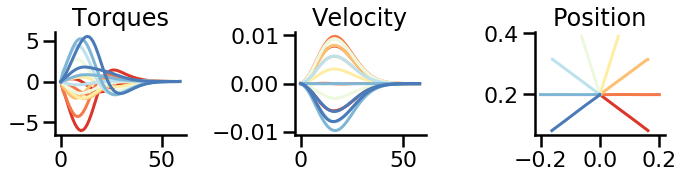

In [4]:
f, ax = plt.subplots(1,3, figsize=(10,3))
for i in range(8):
    ax[0].plot(m_trj[i], c=sns.color_palette()[i])
    ax[1].plot(np.diff(y_trj[i], axis=0), c=sns.color_palette()[i])
    ax[2].plot(y_trj[i,:,0], y_trj[i,:,1])
    
ax[0].set_title("Torques")
ax[1].set_title("Velocity")
ax[2].set_title("Position")
sns.despine()
f.tight_layout()

In [5]:
m_trj = d['torques']*100 
x0 = d['states'][:,0]
#target_trj = d['states'][:,:,:2]
target_trj = interp1d(np.arange(60), d['states'], axis=1, fill_value='extrapolate')(np.arange(0, 60, 0.1))
#u_trj, x_trj = arm_model.rollout(x0[0], m_trj[0])

regu = 0.01
lmbda = 1e-2

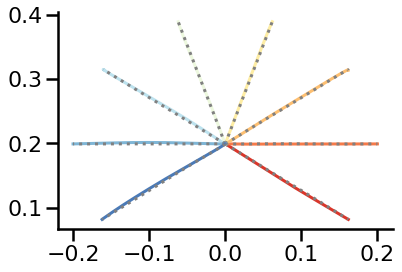

In [6]:
for i in range(8):
    x_trj_new, u_trj_new, cost_trace = ilqr_arm.run_ilqr(x0[i], target_trj[i,:,:2], None, 10, regu, lmbda)
    y_trj_new = arm_model.get_position_trj(x_trj_new)
    plt.plot(y_trj_new[:,0], y_trj_new[:,1])
    y_target = arm_model.get_position_trj(d['states'][i])
    plt.plot(y_target[:,0], y_target[:,1],":", color='gray')
sns.despine()

## Do it at once for all trajectories

In [7]:
x_trj_new, u_trj_new, cost_trace = ilqr_arm.run_ilqr_batch(x0, target_trj[:,:,:2], None, 10, regu, lmbda)

In [8]:
y_trj_new = arm_model.get_position_batch(x_trj_new)
y_target = arm_model.get_position_batch(d['states'])

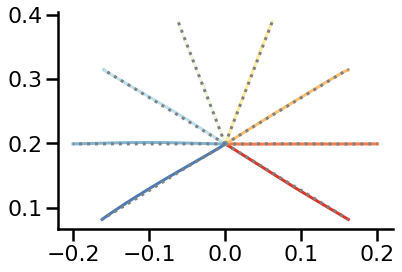

In [9]:
for i in range(8):
    plt.plot(y_trj_new[i, :,0], y_trj_new[i, :,1])
    plt.plot(y_target[i, :,0], y_target[i, :,1],":", color='gray')
sns.despine()

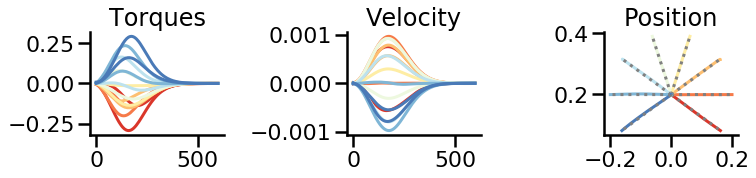

In [10]:
f, ax = plt.subplots(1,3, figsize=(11,3))
for i in range(8):
    ax[0].plot(u_trj_new[i], c=sns.color_palette()[i])
    ax[1].plot(np.diff(y_trj_new[i], axis=0), c=sns.color_palette()[i])
    ax[2].plot(y_trj_new[i,:,0], y_trj_new[i,:,1])
    ax[2].plot(y_target[i, :,0], y_target[i, :,1],":", color='gray')
    
ax[0].set_title("Torques")
ax[1].set_title("Velocity")
ax[2].set_title("Position")
sns.despine()
f.tight_layout()